In [40]:
%pip install yfinance
%pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.3 MB/s eta 0:00:00


In [2]:
# For data manipulation
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

# To fetch financial data
import yfinance as yf

# For visualisation
import matplotlib.pyplot as plt
%matplotlib inline

# Set the ticker as 'EURUSD=X'
forex_data_hour = yf.download('GC=F', period='1mo', interval='1H')

# Set the index to a datetime object
forex_data_hour.index = pd.to_datetime(forex_data_hour.index)

# Display the last five rows
forex_data_hour.tail()

df = pd.DataFrame(forex_data_hour)
prices = df['Close'].values

[*********************100%***********************]  1 of 1 completed


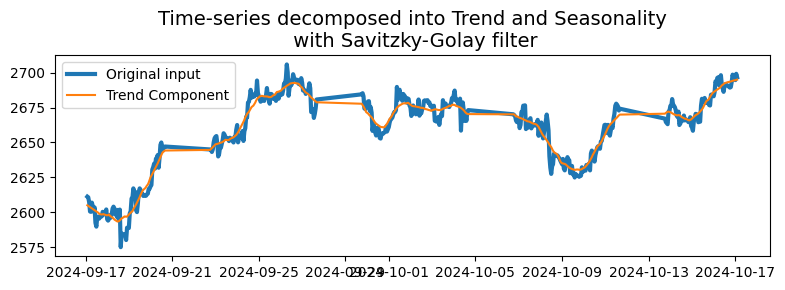

In [5]:
from scipy.signal import savgol_filter

# Create time indices based on the length of prices (0 to len(prices) - 1)
time_indices = np.arange(len(prices))

yvalues = df['Close'].values
yvalues_trend = savgol_filter(yvalues,25,1)
yvalues_seasonal = yvalues-yvalues_trend

fig, ax = plt.subplots(figsize=(8,3))
ax.plot(df.index.values, yvalues, label='Original input',linewidth=3)
ax.plot(df.index.values, yvalues_trend, label='Trend Component')
#ax.plot(df.index.values, yvalues_seasonal, label='Seasonal Component')
ax.legend()
ax.set_title('Time-series decomposed into Trend and Seasonality\n with Savitzky-Golay filter', fontsize=14)
plt.tight_layout()
plt.show()

prices = yvalues_seasonal

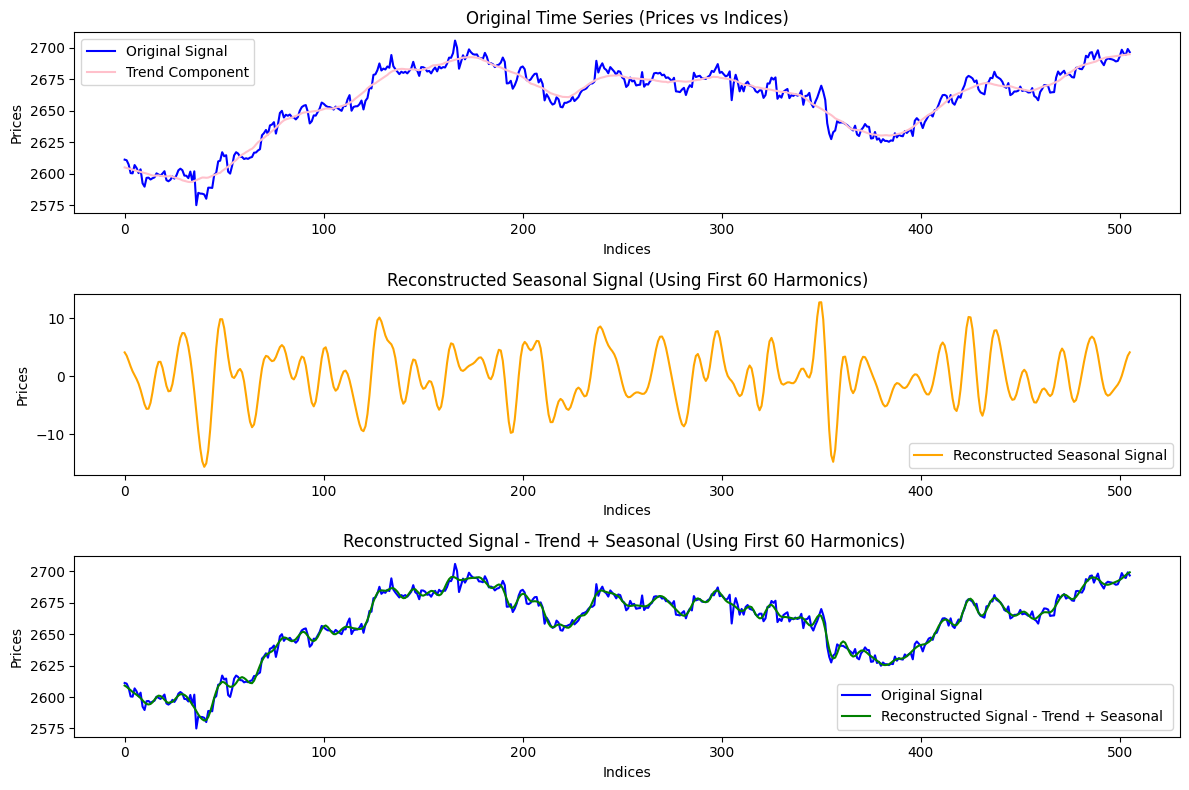

In [10]:

# Perform FFT
N = len(prices)
fft_result = np.fft.fft(prices)
fft_freq = np.fft.fftfreq(N)  # Compute frequency bins

# Only need positive frequencies for real signals
positive_freq_indices = fft_freq >= 0
fft_freq_positive = fft_freq[positive_freq_indices]
fft_result_positive = fft_result[positive_freq_indices]

# Retain only the first few harmonics, including the DC component
num_harmonics = 60  # Adjust this number as needed
frequencies = fft_freq_positive[:num_harmonics]
amplitudes = fft_result_positive[:num_harmonics]

# Reconstruct the signal using the selected harmonics
reconstructed_signal = np.zeros(N)

for i in range(num_harmonics):
    frequency = frequencies[i]
    amplitude = np.abs(amplitudes[i])
    phase = np.angle(amplitudes[i])
    if frequency == 0:
        # DC component (mean value)
        reconstructed_signal += (amplitude / N) * np.ones(N)
    else:
        # Harmonic components
        omega = 2 * np.pi * frequency
        reconstructed_signal += (2 * amplitude / N) * np.cos(omega * time_indices + phase)

# Plot original time series data
plt.figure(figsize=(12, 8))

trend_reconstruct = yvalues_trend + yvalues_seasonal

plt.subplot(3, 1, 1)
plt.plot(time_indices, df['Close'].values, label="Original Signal", color='blue')
plt.plot(time_indices, yvalues_trend, label='Trend Component', color='pink')
#plt.plot(time_indices, trend_reconstruct, label='Trend + Seasonal Reconstruct', color='green')
plt.title("Original Time Series (Prices vs Indices)")
plt.xlabel("Indices")
plt.ylabel("Prices")
plt.legend()

# Plot the reconstructed signal using only a few harmonics
plt.subplot(3, 1, 2)
plt.plot(time_indices, reconstructed_signal, label=f"Reconstructed Seasonal Signal", color='orange')
plt.title(f"Reconstructed Seasonal Signal (Using First {num_harmonics} Harmonics)")
plt.xlabel("Indices")
plt.ylabel("Prices")
plt.legend()

reconstructed_signal_with_trend = yvalues_trend + reconstructed_signal
# Plot the reconstructed signal using only a few harmonics
plt.subplot(3, 1, 3)
plt.plot(time_indices, df['Close'].values, label="Original Signal", color='blue')
plt.plot(time_indices, reconstructed_signal_with_trend, label=f"Reconstructed Signal - Trend + Seasonal ", color='green')
plt.title(f"Reconstructed Signal - Trend + Seasonal (Using First {num_harmonics} Harmonics) ")
plt.xlabel("Indices")
plt.ylabel("Prices")
plt.legend()

plt.tight_layout()
plt.show()

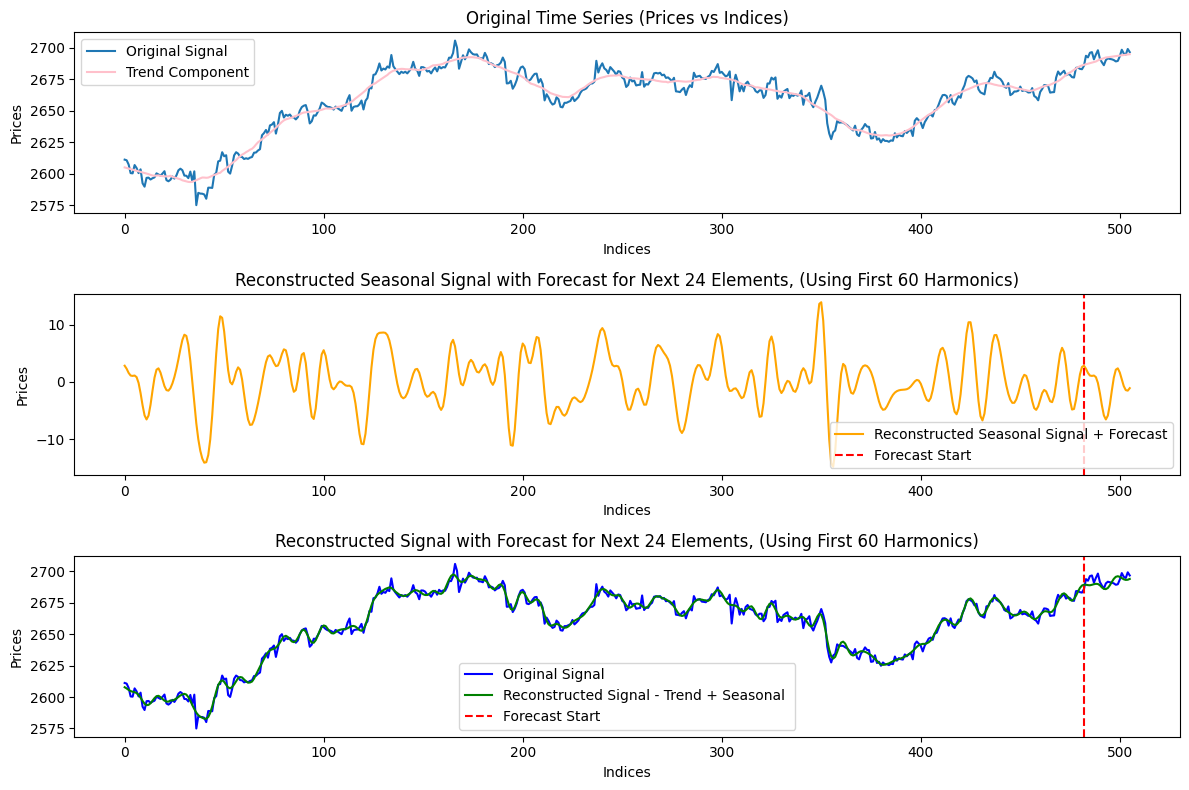

In [14]:
# Define how many elements to exclude (last 24)
exclude_elements = 24
prices_for_fft = prices[:-exclude_elements]  # Remove the last 24 elements for FFT

# Perform FFT on the data excluding the last 24 elements
N = len(prices_for_fft)
fft_result = np.fft.fft(prices_for_fft)
fft_freq = np.fft.fftfreq(N)  # Compute frequency bins

# Only need positive frequencies for real signals
positive_freq_indices = fft_freq >= 0
fft_freq_positive = fft_freq[positive_freq_indices]
fft_result_positive = fft_result[positive_freq_indices]

# Retain the first few harmonics, including the DC component
num_harmonics = 60
frequencies = fft_freq_positive[:num_harmonics]
amplitudes = fft_result_positive[:num_harmonics]

# Create extended indices including future points
total_length = len(prices)
extended_indices = np.arange(total_length)

# Reconstruct the signal using the selected harmonics
reconstructed_signal = np.zeros(total_length)

for i in range(num_harmonics):
    frequency = frequencies[i]
    amplitude = np.abs(amplitudes[i])
    phase = np.angle(amplitudes[i])
    if frequency == 0:  # DC component
        # DC component (mean value)
        reconstructed_signal += (amplitude / N) * np.ones_like(extended_indices)
    else:
        # Other harmonics
        omega = 2 * np.pi * frequency
        reconstructed_signal += (2 * amplitude / N) * np.cos(omega * extended_indices + phase)

# Plot original time series data and the forecast
plt.figure(figsize=(12, 8))

# Plot original signal
plt.subplot(3, 1, 1)
plt.plot(np.arange(len(prices)), df['Close'].values, label="Original Signal")
plt.plot(time_indices, yvalues_trend, label='Trend Component', color='pink')
plt.title("Original Time Series (Prices vs Indices)")
plt.xlabel("Indices")
plt.ylabel("Prices")
plt.legend()

# Plot the reconstructed signal with forecast
plt.subplot(3, 1, 2)
plt.plot(extended_indices, reconstructed_signal, label=f"Reconstructed Seasonal Signal + Forecast", color='orange')
plt.axvline(x=len(prices) - exclude_elements, color='red', linestyle='--', label="Forecast Start")
plt.title(f"Reconstructed Seasonal Signal with Forecast for Next {exclude_elements} Elements, (Using First {num_harmonics} Harmonics)")
plt.xlabel("Indices")
plt.ylabel("Prices")
plt.legend()

reconstructed_signal_with_trend = yvalues_trend + reconstructed_signal
# Plot the reconstructed signal using only a few harmonics
plt.subplot(3, 1, 3)
plt.plot(time_indices, df['Close'].values, label="Original Signal", color='blue')
plt.plot(time_indices, reconstructed_signal_with_trend, label=f"Reconstructed Signal - Trend + Seasonal ", color='green')
plt.axvline(x=len(prices) - exclude_elements, color='red', linestyle='--', label="Forecast Start")
plt.title(f"Reconstructed Signal with Forecast for Next {exclude_elements} Elements, (Using First {num_harmonics} Harmonics)")
plt.xlabel("Indices")
plt.ylabel("Prices")
plt.legend()


plt.tight_layout()
plt.show()

In [47]:
# Define how many elements to exclude (last 48)
forecast_elements = 24

from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(yvalues_trend, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)
smodel.summary()

forecast = smodel.predict(n_periods=forecast_elements)
forecast

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=624.374, Time=4.18 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=3428.177, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=inf, Time=1.13 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=2.65 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=3465.110, Time=0.05 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=658.903, Time=0.48 sec
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=5.33 sec
 ARIMA(1,0,1)(0,1,2)[12] intercept   : AIC=inf, Time=14.13 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=640.641, Time=5.45 sec
 ARIMA(1,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=13.06 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=987.849, Time=0.80 sec
 ARIMA(2,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=5.25 sec
 ARIMA(1,0,2)(0,1,1)[12] intercept   : AIC=432.260, Time=8.10 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=519.681, Time=1.00 sec
 ARIMA(1,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=

array([2695.26907824, 2695.58413985, 2695.97257084, 2696.33026905,
       2696.70208421, 2697.01248023, 2697.38565319, 2697.8192786 ,
       2698.27078735, 2698.64842754, 2699.07913788, 2699.43891561,
       2699.73014993, 2700.10088038, 2700.48168493, 2700.82807709,
       2701.18861454, 2701.48776113, 2701.84971287, 2702.2721452 ,
       2702.71248892, 2703.07899209, 2703.49859333, 2703.84728981])

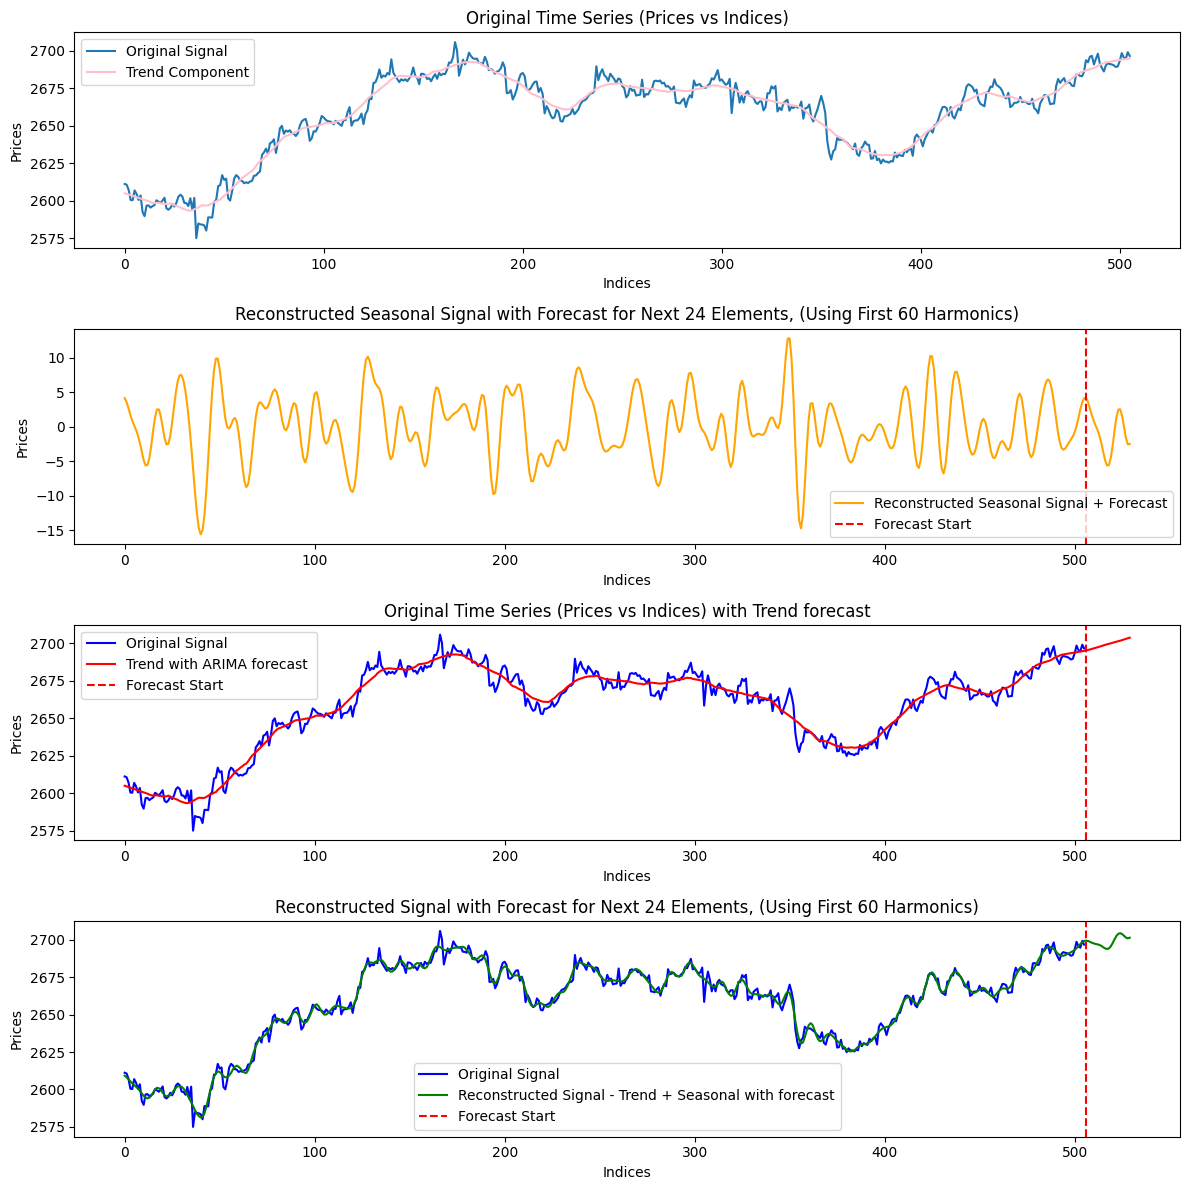

In [48]:


# Perform FFT on the data excluding the last 48 elements
N = len(prices)
fft_result = np.fft.fft(prices)
fft_freq = np.fft.fftfreq(N)  # Compute frequency bins

# Only need positive frequencies for real signals
positive_freq_indices = fft_freq >= 0
fft_freq_positive = fft_freq[positive_freq_indices]
fft_result_positive = fft_result[positive_freq_indices]

# Retain the first few harmonics, including the DC component
num_harmonics = 60
frequencies = fft_freq_positive[:num_harmonics]
amplitudes = fft_result_positive[:num_harmonics]

# Create extended indices including future points
total_length = len(prices) + forecast_elements
extended_indices = np.arange(total_length)

# Reconstruct the signal using the selected harmonics
reconstructed_signal = np.zeros(total_length)

for i in range(num_harmonics):
    frequency = frequencies[i]
    amplitude = np.abs(amplitudes[i])
    phase = np.angle(amplitudes[i])
    if frequency == 0:  # DC component
        # DC component (mean value)
        reconstructed_signal += (amplitude / N) * np.ones_like(extended_indices)
    else:
        # Other harmonics
        omega = 2 * np.pi * frequency
        reconstructed_signal += (2 * amplitude / N) * np.cos(omega * extended_indices + phase)

# Plot original time series data and the forecast
plt.figure(figsize=(12, 12))

# Plot original signal
plt.subplot(4, 1, 1)
plt.plot(np.arange(len(prices)), df['Close'].values, label="Original Signal")
plt.plot(time_indices, yvalues_trend, label='Trend Component', color='pink')
plt.title("Original Time Series (Prices vs Indices)")
plt.xlabel("Indices")
plt.ylabel("Prices")
plt.legend()

# Plot the reconstructed signal with forecast
plt.subplot(4, 1, 2)
plt.plot(extended_indices, reconstructed_signal, label=f"Reconstructed Seasonal Signal + Forecast", color='orange')
plt.axvline(x=len(prices), color='red', linestyle='--', label="Forecast Start")
plt.title(f"Reconstructed Seasonal Signal with Forecast for Next {exclude_elements} Elements, (Using First {num_harmonics} Harmonics)")
plt.xlabel("Indices")
plt.ylabel("Prices")
plt.legend()


yvalues_trend_forecast = np.concatenate((yvalues_trend, forecast))

plt.subplot(4, 1, 3)
plt.plot(time_indices, df['Close'].values, label="Original Signal", color='blue')
plt.plot(extended_indices, yvalues_trend_forecast, label=f"Trend with ARIMA forecast ", color='red')
plt.axvline(x=len(prices), color='red', linestyle='--', label="Forecast Start")
plt.title(f"Original Time Series (Prices vs Indices) with Trend forecast")
plt.xlabel("Indices")
plt.ylabel("Prices")
plt.legend()

reconstructed_signal_with_trend = yvalues_trend_forecast + reconstructed_signal
# Plot the reconstructed signal using only a few harmonics
plt.subplot(4, 1, 4)
plt.plot(time_indices, df['Close'].values, label="Original Signal", color='blue')
plt.plot(extended_indices, reconstructed_signal_with_trend, label=f"Reconstructed Signal - Trend + Seasonal with forecast", color='green')
plt.axvline(x=len(prices), color='red', linestyle='--', label="Forecast Start")
plt.title(f"Reconstructed Signal with Forecast for Next {exclude_elements} Elements, (Using First {num_harmonics} Harmonics)")
plt.xlabel("Indices")
plt.ylabel("Prices")
plt.legend()


plt.tight_layout()
plt.show()